In Spark, there is one paritcular recommendation algorithm, Alternating Least Squares (ALS). This algorithm leverages collaborative filtering, which makes recommendations based only on which items users interacted with in the past. That is, it does not require or use any additional features about the users or the items.

In [14]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import col, expr

# select 4 cores to process this
spark = SparkSession\
        .builder\
        .appName("ALSExample")\
        .config("spark.executor.cores", '4')\
        .getOrCreate()

# Loading data

In [46]:
ratings = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load("data/ml-latest-small/ratings.csv")

ratings = ratings.withColumn("timestamp", f.to_timestamp(f.from_unixtime("timestamp")))
ratings.printSchema()
ratings.createOrReplaceTempView("dfTable")

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [47]:
ratings.show()

+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|      1|   4.0|2000-07-30 19:45:03|
|     1|      3|   4.0|2000-07-30 19:20:47|
|     1|      6|   4.0|2000-07-30 19:37:04|
|     1|     47|   5.0|2000-07-30 20:03:35|
|     1|     50|   5.0|2000-07-30 19:48:51|
|     1|     70|   3.0|2000-07-30 19:40:00|
|     1|    101|   5.0|2000-07-30 19:14:28|
|     1|    110|   4.0|2000-07-30 19:36:16|
|     1|    151|   5.0|2000-07-30 20:07:21|
|     1|    157|   5.0|2000-07-30 20:08:20|
|     1|    163|   5.0|2000-07-30 20:00:50|
|     1|    216|   5.0|2000-07-30 19:20:08|
|     1|    223|   3.0|2000-07-30 19:16:25|
|     1|    231|   5.0|2000-07-30 19:19:39|
|     1|    235|   4.0|2000-07-30 19:15:08|
|     1|    260|   5.0|2000-07-30 19:28:00|
|     1|    296|   3.0|2000-07-30 19:49:27|
|     1|    316|   3.0|2000-07-30 19:38:30|
|     1|    333|   5.0|2000-07-30 19:19:39|
|     1|    349|   4.0|2000-07-3

In [48]:
movies = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load("data/ml-latest-small/movies.csv")
movies.printSchema()
movies.createOrReplaceTempView("dfTable")

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [49]:
movie_names = movies.select("movieID", "title", "genres")
movie_names.show(5)

+-------+--------------------+--------------------+
|movieID|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



# Exploratory Data Analysis

In [50]:
ratings.count()

100836

Movie's with the most ratings

In [51]:
number_of_ratings = ratings.groupby("movieID").count()

joinExpression = number_of_ratings["movieID"] == movie_names['movieID']
joinType = "left"
total_ratings_per_movie = number_of_ratings.join(movie_names, ["movieID"], joinType).orderBy("count", ascending=False)
total_ratings_per_movie.withColumnRenamed("count", "number of user ratings").show()

+-------+----------------------+--------------------+--------------------+
|movieID|number of user ratings|               title|              genres|
+-------+----------------------+--------------------+--------------------+
|    356|                   329| Forrest Gump (1994)|Comedy|Drama|Roma...|
|    318|                   317|Shawshank Redempt...|         Crime|Drama|
|    296|                   307| Pulp Fiction (1994)|Comedy|Crime|Dram...|
|    593|                   279|Silence of the La...|Crime|Horror|Thri...|
|   2571|                   278|  Matrix, The (1999)|Action|Sci-Fi|Thr...|
|    260|                   251|Star Wars: Episod...|Action|Adventure|...|
|    480|                   238|Jurassic Park (1993)|Action|Adventure|...|
|    110|                   237|   Braveheart (1995)|    Action|Drama|War|
|    589|                   224|Terminator 2: Jud...|       Action|Sci-Fi|
|    527|                   220|Schindler's List ...|           Drama|War|
|   2959|                

Distribution of rating scores

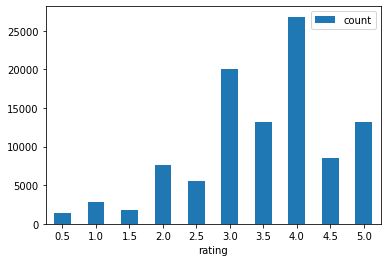

In [52]:
ratings_count = ratings.groupby("rating").count()
ratings_count.toPandas().sort_values(by='rating', ascending=True).plot.bar(x='rating', y='count', rot=0)

In [53]:
movies.where("genres like '%Action%'").show(10, truncate=False)

+-------+-----------------------------------------+----------------------------------+
|movieId|title                                    |genres                            |
+-------+-----------------------------------------+----------------------------------+
|6      |Heat (1995)                              |Action|Crime|Thriller             |
|9      |Sudden Death (1995)                      |Action                            |
|10     |GoldenEye (1995)                         |Action|Adventure|Thriller         |
|15     |Cutthroat Island (1995)                  |Action|Adventure|Romance          |
|20     |Money Train (1995)                       |Action|Comedy|Crime|Drama|Thriller|
|23     |Assassins (1995)                         |Action|Crime|Thriller             |
|42     |Dead Presidents (1995)                   |Action|Crime|Drama                |
|44     |Mortal Kombat (1995)                     |Action|Adventure|Fantasy          |
|66     |Lawnmower Man 2: Beyond Cyberspace

In [54]:
movie_genres = movies.withColumn("genres_array", f.split("genres", "\|"))\
                      .withColumn("genre", f.explode("genres_array"))
movie_genres.show()

+-------+--------------------+--------------------+--------------------+---------+
|movieId|               title|              genres|        genres_array|    genre|
+-------+--------------------+--------------------+--------------------+---------+
|      1|    Toy Story (1995)|Adventure|Animati...|[Adventure, Anima...|Adventure|
|      1|    Toy Story (1995)|Adventure|Animati...|[Adventure, Anima...|Animation|
|      1|    Toy Story (1995)|Adventure|Animati...|[Adventure, Anima...| Children|
|      1|    Toy Story (1995)|Adventure|Animati...|[Adventure, Anima...|   Comedy|
|      1|    Toy Story (1995)|Adventure|Animati...|[Adventure, Anima...|  Fantasy|
|      2|      Jumanji (1995)|Adventure|Childre...|[Adventure, Child...|Adventure|
|      2|      Jumanji (1995)|Adventure|Childre...|[Adventure, Child...| Children|
|      2|      Jumanji (1995)|Adventure|Childre...|[Adventure, Child...|  Fantasy|
|      3|Grumpier Old Men ...|      Comedy|Romance|   [Comedy, Romance]|   Comedy|
|   

In [55]:
movie_genres.groupby("genre")\
      .count()\
      .sort(f.col("count").desc())\
      .show()

+------------------+-----+
|             genre|count|
+------------------+-----+
|             Drama| 4361|
|            Comedy| 3756|
|          Thriller| 1894|
|            Action| 1828|
|           Romance| 1596|
|         Adventure| 1263|
|             Crime| 1199|
|            Sci-Fi|  980|
|            Horror|  978|
|           Fantasy|  779|
|          Children|  664|
|         Animation|  611|
|           Mystery|  573|
|       Documentary|  440|
|               War|  382|
|           Musical|  334|
|           Western|  167|
|              IMAX|  158|
|         Film-Noir|   87|
|(no genres listed)|   34|
+------------------+-----+



In [56]:
movie_genres.where("genre == '(no genres listed)'").show(35)

+-------+--------------------+------------------+--------------------+------------------+
|movieId|               title|            genres|        genres_array|             genre|
+-------+--------------------+------------------+--------------------+------------------+
| 114335|   La cravate (1957)|(no genres listed)|[(no genres listed)]|(no genres listed)|
| 122888|      Ben-hur (2016)|(no genres listed)|[(no genres listed)]|(no genres listed)|
| 122896|Pirates of the Ca...|(no genres listed)|[(no genres listed)]|(no genres listed)|
| 129250|   Superfast! (2015)|(no genres listed)|[(no genres listed)]|(no genres listed)|
| 132084| Let It Be Me (1995)|(no genres listed)|[(no genres listed)]|(no genres listed)|
| 134861|Trevor Noah: Afri...|(no genres listed)|[(no genres listed)]|(no genres listed)|
| 141131|    Guardians (2016)|(no genres listed)|[(no genres listed)]|(no genres listed)|
| 141866|   Green Room (2015)|(no genres listed)|[(no genres listed)]|(no genres listed)|
| 142456|T

In [57]:
ratings.groupBy("movieId").agg(
    f.count("*"),
    f.min("rating"),
    f.max("rating"),
    f.avg("rating"),
    f.min("timestamp"),
    f.max("timestamp")
).show()

+-------+--------+-----------+-----------+------------------+-------------------+-------------------+
|movieId|count(1)|min(rating)|max(rating)|       avg(rating)|     min(timestamp)|     max(timestamp)|
+-------+--------+-----------+-----------+------------------+-------------------+-------------------+
|   1580|     165|        0.5|        5.0| 3.487878787878788|1997-07-07 13:07:18|2018-07-22 14:30:52|
|   2366|      25|        1.5|        5.0|              3.64|1999-11-04 15:23:49|2018-02-20 10:20:35|
|   3175|      75|        1.0|        5.0|              3.58|1999-12-26 14:01:31|2018-06-25 06:07:19|
|   1088|      42|        1.0|        5.0| 3.369047619047619|1997-04-07 08:36:08|2018-01-17 01:52:47|
|  32460|       4|        3.5|        5.0|              4.25|2011-12-18 19:21:21|2017-04-21 21:12:30|
|  44022|      23|        1.0|        4.5| 3.217391304347826|2006-10-25 19:02:59|2018-03-07 07:38:56|
|  96488|       4|        4.0|        4.5|              4.25|2014-11-08 16:17:07|2

In [60]:
ratings.groupBy("userId").agg(
    f.collect_set("movieId").alias("movieIds"),
    f.count("*"),
    f.avg("rating"),
    f.min("rating").alias("minumum rating"),
    f.max("rating").alias("maximum rating")
).show()

+------+--------------------+--------+------------------+--------------+--------------+
|userId|            movieIds|count(1)|       avg(rating)|minumum rating|maximum rating|
+------+--------------------+--------+------------------+--------------+--------------+
|   148|[356, 76093, 1228...|      48|3.7395833333333335|           1.5|           5.0|
|   463|[3753, 356, 110, ...|      33| 3.787878787878788|           2.0|           5.0|
|   471|[356, 1, 92259, 1...|      28|             3.875|           2.0|           5.0|
|   496|[7151, 1221, 4191...|      29| 3.413793103448276|           1.0|           5.0|
|   243|[161, 356, 466, 1...|      36| 4.138888888888889|           3.0|           5.0|
|   392|[1221, 1127, 3298...|      25|               3.2|           1.0|           5.0|
|   540|[589, 2107, 2841,...|      42|               4.0|           2.0|           5.0|
|    31|[1, 1200, 612, 12...|      50|              3.92|           1.0|           5.0|
|   516|[4306, 4429, 4349...|   

### if you don't have a indexed movieID, use StringIndexer to change the movie names into indexes

# Build Model and Fit

In [74]:
from pyspark.ml.recommendation import ALS

#split data into training and test set
training, test = ratings.randomSplit([0.8, 0.2])


als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
                    coldStartStrategy="drop")

In [75]:
alsModel = als.fit(training)
predictions = alsModel.transform(test)

ALS effectively predicted the ratings that a user would give for a particular movie

In [76]:
predictions.show(10)

+------+-------+------+-------------------+----------+
|userId|movieId|rating|          timestamp|prediction|
+------+-------+------+-------------------+----------+
|   436|    471|   3.0|1996-05-31 09:09:47|   3.98593|
|   218|    471|   4.0|2005-03-24 00:41:14|  2.101538|
|   500|    471|   1.0|2001-11-12 01:20:17|  2.372246|
|    57|    471|   3.0|2000-09-24 01:00:04| 3.8274581|
|   555|    471|   3.0|2001-01-06 02:08:53| 4.7445965|
|   312|    471|   4.0|2003-01-21 18:59:24| 3.4206297|
|   216|    471|   3.0|2000-11-26 04:24:01| 3.7141562|
|   373|    471|   5.0|1996-11-01 06:39:48|  3.665931|
|   104|    471|   4.5|2009-03-26 23:45:29| 3.9492128|
|    44|    833|   2.0|1997-07-18 19:57:17| 3.4144633|
+------+-------+------+-------------------+----------+
only showing top 10 rows



# Evaluate

When covering the cold-start strategy, we can set up an automatic model evaluator when working with ALS. One thing that may not be immediately obvious is that this recommendation problem is really just a kind of regression problem. Since we’re predicting values (ratings) for given users, we want to optimize for reducing the total difference between our users’ ratings and the true values. We can do this using the RegressionEvaluator.

In [78]:
# in Python
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator()\
              .setMetricName("rmse")\
              .setLabelCol("rating")\
              .setPredictionCol("prediction")

rmse = evaluator.evaluate(predictions.na.drop())
print("Root-mean-square error = %f" % rmse)

Root-mean-square error = 1.077731


This error isn't the best! The model can be improvied further by tuning the hyperparameters

# CV + GRIDSEARCH

In [79]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

parameter_grid = (
    ParamGridBuilder()
    .addGrid(als.rank, [1, 5, 10])
    .addGrid(als.maxIter, [20])
    .addGrid(als.regParam, [0.05, 0.1])
    .build()
)

In [81]:
crossvalidator = CrossValidator(
    estimator=als,
    estimatorParamMaps=parameter_grid,
    evaluator=evaluator,
    numFolds=2,
)

crossval_model = crossvalidator.fit(training)
predictions = crossval_model.transform(test)


In [82]:
rmse = evaluator.evaluate(predictions.na.drop())
print(rmse)

0.8777585752789658


much better!

In [83]:
alsModel = crossval_model.bestModel

# Recommendation Results

We can now output the top 𝘬 recommendations for each user or movie. The model’s recommendForAllUsers method returns a DataFrame of a userId, an array of recommendations, as well as a rating for each of those movies. recommendForAllItems returns a DataFrame of a movieID, as well as the top users for that movie:

In [84]:
from pyspark.sql.functions import col

# generate top 10 movie recs for each user
alsModel.recommendForAllUsers(10)\
  .selectExpr("userId", "explode(recommendations)").show(5)

# generate top 10 user recommendations for each movie 
alsModel.recommendForAllItems(10)\
  .selectExpr("movieID", "explode(recommendations)").show(5)

+------+------------------+
|userId|               col|
+------+------------------+
|   471|[89904, 5.0465307]|
|   471| [96004, 4.944986]|
|   471|  [7008, 4.784727]|
|   471|  [6461, 4.772862]|
|   471|  [7767, 4.708182]|
+------+------------------+
only showing top 5 rows

+-------+----------------+
|movieID|             col|
+-------+----------------+
|   1580|   [53, 5.04259]|
|   1580| [543, 4.742526]|
|   1580| [276, 4.728681]|
|   1580| [452, 4.611367]|
|   1580|[243, 4.5599465]|
+-------+----------------+
only showing top 5 rows



### select test user

In [90]:
test_userId = 78

test_user = ratings.filter(ratings['userId'] == test_userId)

joinExpression = test_user["movieID"] == movie_names['movieID']
joinType = 'left'

test_user_profile = test_user.join(movie_names, joinExpression, joinType)\
 .orderBy('rating', ascending = False)

test_user_profile.select("userId", "title", "rating").show(truncate = False)

+------+------------------------------------------------------------------------------+------+
|userId|title                                                                         |rating|
+------+------------------------------------------------------------------------------+------+
|78    |Terminator, The (1984)                                                        |5.0   |
|78    |Die Hard (1988)                                                               |5.0   |
|78    |Airplane! (1980)                                                              |5.0   |
|78    |Ghostbusters (a.k.a. Ghost Busters) (1984)                                    |4.5   |
|78    |Dodgeball: A True Underdog Story (2004)                                       |4.5   |
|78    |Terminator 2: Judgment Day (1991)                                             |4.5   |
|78    |Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)|4.5   |
|78    |Matrix, The (1999)                        

In [86]:
unique_movies = movies.select("title").distinct()


movies_read = test_user_profile.select("title").distinct()


### filter for recommendation results and join with movie names

In [91]:
userRecs = alsModel.recommendForAllUsers(10)

test_userRecs = userRecs.filter(userRecs['userId'] == test_userId)\
                    .selectExpr("userId", "explode(recommendations)")

test_userRecs = test_userRecs.select("userId", 'col.*')

In [92]:
joinExpression = test_userRecs["movieID"] == movie_names['movieID']
joinType = "inner"

recommended_movies = test_userRecs.join(movie_names, joinExpression, joinType)

recommended_movies.select("title", "rating").show(truncate = False)

+-------------------------------------------------------+---------+
|title                                                  |rating   |
+-------------------------------------------------------+---------+
|Dune (2000)                                            |4.9018517|
|Last Detail, The (1973)                                |4.807784 |
|Isle of Dogs (2018)                                    |4.786659 |
|Come and See (Idi i smotri) (1985)                     |4.7452154|
|Bossa Nova (2000)                                      |4.555276 |
|My Wife is an Actress (Ma Femme est une Actrice) (2001)|4.5537047|
|Strictly Sexual (2008)                                 |4.379389 |
|8 Heads in a Duffel Bag (1997)                         |4.349611 |
|Band of Brothers (2001)                                |4.328229 |
|World of Tomorrow (2015)                               |4.3272247|
+-------------------------------------------------------+---------+



### can also find top users for a given movie

In [93]:
test_movieID = 177

movie_names.filter(movie_names['movieID'] == test_movieID).show()

+-------+--------------------+------+
|movieID|               title|genres|
+-------+--------------------+------+
|    177|Lord of Illusions...|Horror|
+-------+--------------------+------+



In [94]:
movieRecs = alsModel.recommendForAllItems(10)\
                    .selectExpr("movieID", "explode(recommendations)")

test_movieRec = movieRecs.filter(movieRecs['movieID'] == test_movieID)\
                        .select("movieID", "col.*")

test_movieRec.show()

+-------+------+---------+
|movieID|userId|   rating|
+-------+------+---------+
|    177|    22| 4.879172|
|    177|   175|4.4150743|
|    177|    15| 4.411814|
|    177|   115| 4.331586|
|    177|   244| 4.330542|
|    177|    90| 4.284384|
|    177|   572| 4.126728|
|    177|    42| 4.096353|
|    177|   310| 4.090833|
|    177|   528|4.0833664|
+-------+------+---------+



In [98]:
test_movieRec.join(ratings, ['movieID', 'userId'], how='leftanti').show()

+-------+------+---------+
|movieID|userId|   rating|
+-------+------+---------+
|    177|    22| 4.879172|
|    177|   175|4.4150743|
|    177|    15| 4.411814|
|    177|   115| 4.331586|
|    177|   244| 4.330542|
|    177|    90| 4.284384|
|    177|   572| 4.126728|
|    177|    42| 4.096353|
|    177|   310| 4.090833|
|    177|   528|4.0833664|
+-------+------+---------+



# Further evaluation metrics

A RankingMetric allows us to compare our recommendations with an actual set of ratings (or preferences) expressed by a given user. RankingMetric does not focus on the value of the rank but rather whether or not our algorithm recommends an already ranked item again to a user. 

First, we need to collect a set of highly ranked movies for a given user. In our case, we’re going to use a rather low threshold: movies ranked above 2.5. Tuning this value will largely be a business decision:

In [ ]:
# in Python
from pyspark.mllib.evaluation import RankingMetrics, RegressionMetrics
from pyspark.sql.functions import col, expr
perUserActual = predictions\
  .where("rating > 2.5")\
  .groupBy("userId")\
  .agg(expr("collect_set(movieID) as movies"))

At this point, we have a collection of users, along with a truth set of previously ranked movies for each user. Now we will get our top 10 recommendations from our algorithm on a per-user basis. We will then see if the top 10 recommendations show up in our truth set. If we have a well-trained model, it will correctly recommend the movies a user already liked. If it doesn’t, it may not have learned enough about each particular user to successfully reflect their preferences:

In [ ]:
perUserPredictions = predictions\
  .orderBy(col("userId"), expr("prediction DESC"))\
  .groupBy("userId")\
  .agg(expr("collect_list(movieID) as movies"))

Now we have two DataFrames, one of predictions and another the top-ranked items for a particular user. We can pass them into the RankingMetrics object. This object accepts an RDD of these combinations, as you can see in the following join and RDD conversion:

In [ ]:
# in Python
perUserActualvPred = perUserActual.join(perUserPredictions, ["userId"]).rdd\
  .map(lambda row: (row[1], row[2][:15]))
ranks = RankingMetrics(perUserActualvPred)

Now we can see the metrics from that ranking. For instance, we can see how precise our algorithm is with the mean average precision. We can also get the precision at certain ranking points, for instance, to see where the majority of the positive recommendations fall:

In [ ]:
ranks.meanAveragePrecision
ranks.precisionAt(5)